In [20]:
from myenv.models.candlestick import Candlestick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


candlestick = Candlestick()

bitcoin_prices = candlestick.to_df()

bitcoin_prices.describe()

bitcoin_prices['day_name'] = bitcoin_prices[['open']].apply(
    lambda x: x.name.strftime("%A"), axis=1)

total = bitcoin_prices.iloc[:,0].count()



# GIAO DỊCH TRONG BIÊN ĐỘ


<Figure size 432x288 with 0 Axes>

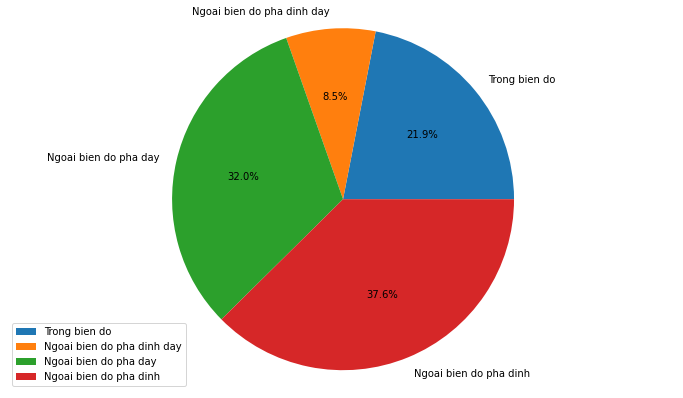

Đối với tập dự liệu giá BTC từ 2017-08-17 đến 2021-07-17, xác suất của việc mức giá cao nhất bị phá vỡ là 46.1%, mức giá thấp nhất bị phá vỡ là 40.5% và cả hai đỉnh đáy bị phá vỡ là 8.5%.
Có ít hơn 21.9% số ngày là những ngày giao dịch trong biên độ


In [4]:
data = [0]

for index in range(0, total):
    if index < 1:
        continue
    
    # trong biên độ
    inside_bar_type = 0
    current_row = bitcoin_prices.iloc[index]
    previous_row = bitcoin_prices.iloc[index - 1]

    if current_row['low'] < previous_row['low'] and current_row['high'] > previous_row['high']:
        # Ngoài biên độ phá vỡ đỉnh và dáy
        inside_bar_type = 1
    elif current_row['low'] < previous_row['low']:
        # Ngoài biên độ phá vỡ dáy
        inside_bar_type = 2
    elif current_row['high'] > previous_row['high']:
        # Ngoài biên độ phá vỡ đỉnh
        inside_bar_type = 3

    data.append(inside_bar_type)

bitcoin_prices['inside_bar_type'] = data

group_inside_bar_type = bitcoin_prices.groupby(
    'inside_bar_type').inside_bar_type.count()

labels = 'Trong bien do', 'Ngoai bien do pha dinh day', 'Ngoai bien do pha day', 'Ngoai bien do pha dinh'
sizes = [group_inside_bar_type.loc[0],
         group_inside_bar_type.loc[1], group_inside_bar_type.loc[2], group_inside_bar_type.loc[3]]

plt.figure()
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend()
plt.show()

first_date = bitcoin_prices.iloc[0].name.date()
last_date = bitcoin_prices.iloc[-1].name.date()
probability_break_high = '{:.1%}'.format((group_inside_bar_type.loc[3] +
                                          group_inside_bar_type.loc[1])/total)
probability_break_low = '{:.1%}'.format((group_inside_bar_type.loc[2] +
                                         group_inside_bar_type.loc[1])/total)
probability_break_both = '{:.1%}'.format(group_inside_bar_type.loc[1]/total)
probability_inside_day = '{:.1%}'.format(group_inside_bar_type.loc[0]/total)

print(
    f"Đối với tập dự liệu giá BTC từ {first_date} đến {last_date}, xác suất của việc mức giá cao nhất bị phá vỡ là {probability_break_high}, mức giá thấp nhất bị phá vỡ là {probability_break_low} và cả hai đỉnh đáy bị phá vỡ là {probability_break_both}.")
print(
    f"Có ít hơn {probability_inside_day} số ngày là những ngày giao dịch trong biên độ")


# HIỆU ỨNG NGÀY TRONG TUẦN VÀ HÀNH VI THỊ TRƯỜNG

In [96]:
import datetime

candlestick_week = Candlestick(interval="week")

bitcoin_prices_week = candlestick_week.to_df()

bitcoin_prices_week.describe()

bitcoin_prices_week['end_week'] = bitcoin_prices_week[['high']].apply(
    lambda x: x.name.date() + datetime.timedelta(days=6), axis=1)


bitcoin_prices[bitcoin_prices_week.iloc[0].name.strftime(
    "%Y-%m-%d"):"2018-11-02"]

def min_low_in_week(x):
    df_week = bitcoin_prices[x.name.strftime("%Y-%m-%d"):x['end_week'].strftime("%Y-%m-%d")]
    return df_week[df_week.low == df_week.low.min()].iloc[0, 4]


def max_high_in_week(x):
    df_week = bitcoin_prices[x.name.strftime(
        "%Y-%m-%d"):x['end_week'].strftime("%Y-%m-%d")]
    return df_week[df_week.high == df_week.high.max()].iloc[0, 4]


bitcoin_prices_week['min_low_in_week'] = bitcoin_prices_week[[
    'end_week']].apply(lambda x: min_low_in_week(x), axis=1)


bitcoin_prices_week['max_high_in_week'] = bitcoin_prices_week[[
    'end_week']].apply(lambda x: max_high_in_week(x), axis=1)

group_min_low_in_week = bitcoin_prices_week.groupby(
    'min_low_in_week').min_low_in_week.count()

group_max_high_in_week = bitcoin_prices_week.groupby(
    'max_high_in_week').max_high_in_week.count()

print(group_min_low_in_week)
print(group_max_high_in_week)

min_low_in_week
Friday       23
Monday       71
Saturday      9
Sunday       29
Thursday     26
Tuesday      26
Wednesday    20
Name: min_low_in_week, dtype: int64
max_high_in_week
Friday       19
Monday       59
Saturday     29
Sunday       38
Thursday     16
Tuesday      21
Wednesday    22
Name: max_high_in_week, dtype: int64
